# Semi-linear SDE solvers

We simulate the following semi-linear SDE:
$$
    dY_t = -Y_t dt + c f(Y_t) dt + dW_t
$$

where $f$ is some non-linear function (see `drift_f` below) and $c$ is a constant, which we vary between 1.0, 0.1, and 0.01. We compare the strong order of convergence of SemiShARK, SemiSEA, and ShARK for this SDE.

In [2]:
from warnings import simplefilter

import jax
import jax.numpy as jnp
import jax.random as jr
from equinox.internal import ω


simplefilter(action="ignore", category=FutureWarning)

from test.helpers import path_l2_dist, SDE, simple_batch_sde_solve

import diffrax
from diffrax import (
    ControlTerm,
    MultiTerm,
    SemiLinearTerm,
    SemiSEA,  # noqa
    SemiShARK,
    ShARK,  # noqa
    SpaceTimeLevyArea,
)
from diffrax._solver.semi_shark import AbstractSemiShARK  # noqa
from drawing_and_evaluating import (
    constant_step_strong_order,
    draw_order_multiple_dict,
    get_fine_solutions,  # noqa
    load_order_results,
    save_order_results,
    save_ref_sol,  # noqa
)


jax.config.update("jax_enable_x64", True)

y0 = jnp.array([1.0, 1.0])
t0, t1 = 0.0, 8.0


def get_semi_sde(t0, t1, y0, c):
    def drift_f(t, y, args):
        dy0 = ((y[0] * y[1]) / jnp.sum(y**2) + 1) * jnp.sin(y[1])
        dy1 = y[1] * (y[0] ** 2) / (1 + 0.1 * y[0] ** 4) + jnp.sin(y[0])
        return c * jnp.array([dy0, dy1], dtype=y.dtype)

    semi_term = SemiLinearTerm(f=drift_f, gamma=-1.0)
    ode_term = semi_term.to_ode()

    def diffusion_vf(t, y, args):
        return jnp.eye(2)

    def get_terms_semi(bm):
        return MultiTerm(semi_term, ControlTerm(diffusion_vf, bm))

    def get_terms_regular(bm):
        return MultiTerm(ode_term, ControlTerm(diffusion_vf, bm))

    vbt_shape = (2,)

    sde_semi = SDE(get_terms_semi, None, y0, t0, t1, vbt_shape)
    sde_regular = SDE(get_terms_regular, None, y0, t0, t1, vbt_shape)

    return sde_semi, sde_regular


c1, c2, c3, c4 = 1.0, 0.1, 0.01, 0.0

sde1_semi, sde1_regular = get_semi_sde(t0, t1, y0, c1)
sde2_semi, sde2_regular = get_semi_sde(t0, t1, y0, c2)
sde3_semi, sde3_regular = get_semi_sde(t0, t1, y0, c3)
sde4_semi, sde4_regular = get_semi_sde(t0, t1, y0, c4)

num_samples = 1000
keys = jr.split(jr.key(0), num_samples)

bm_tol = 2**-11
levels = (4, 10)
lv_crs, lv_fine = levels
lv_ref = 13

In [3]:
# compute the reference solutions using ShARK
# ref_sols1 = get_fine_solutions(
#     keys, sde1_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols1, "semi_sde_c1")
ref_sols1 = jnp.load("data/ref_sol_semi_sde_c1.npy")

# ref_sols2 = get_fine_solutions(
#     keys, sde2_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols2, "semi_sde_c2")
ref_sols2 = jnp.load("data/ref_sol_semi_sde_c2.npy")

# ref_sols3 = get_fine_solutions(
#     keys, sde3_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols3, "semi_sde_c3")
ref_sols3 = jnp.load("data/ref_sol_semi_sde_c3.npy")

# ref_sols4 = get_fine_solutions(
#     keys, sde4_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols4, "semi_sde_c4")
ref_sols4 = jnp.load("data/ref_sol_semi_sde_c4.npy")

In [4]:
# A setup for easily prototyping and testing changes to the step of SemiShARK


def get_errors(keys, solver, sde, ref_sol):
    step_ts = jnp.linspace(t0, t1, 2**6 + 1, dtype=jnp.float64, endpoint=True)
    controller = diffrax.StepTo(ts=step_ts)
    save_ts = jnp.linspace(t0, t1, 2**lv_crs + 1, dtype=jnp.float64, endpoint=True)
    saveat = diffrax.SaveAt(ts=save_ts)
    sols = simple_batch_sde_solve(
        keys, sde, solver, SpaceTimeLevyArea, None, controller, bm_tol, saveat
    )
    errors = path_l2_dist(sols.ys, ref_sol)
    return errors


errors_semishark0_sde3 = get_errors(keys, SemiShARK(), sde3_semi, ref_sols3)
errors_semishark0_sde1 = get_errors(keys, SemiShARK(), sde1_semi, ref_sols1)

100.00%|██████████| [00:00<00:00, 1089.79%/s]
100.00%|██████████| [00:00<00:00, 1070.11%/s]


In [22]:
class SemiShARK1(AbstractSemiShARK):
    def inner_step(self, t0, t1, y0, w, hh, g, f, args):
        h = t1 - t0

        gh = h * g
        exp_gh, phi1_gh, phi2_gh, phi3_gh, phi4_gh, phi5_gh = self.phi_0_to_5(gh)

        w_tilde = ((1 + gh / 2) * w**ω + (gh + (gh**2) / 2) * hh**ω).ω
        w_tilde2 = ((1 + gh / 2) * w**ω + gh * hh**ω).ω
        hh_tilde = (phi4_gh * w**ω + phi5_gh * hh**ω).ω
        # hh_tilde = hh

        # The first stage y1 is evaluated at time t0
        y1 = (y0**ω + hh_tilde**ω).ω

        f1 = f(t0, y1, args)

        # The second stage y2 is evaluated at time t0 + alpha * h
        alpha = 5 / 6
        agh = alpha * gh
        exp_agh, phi1_agh = self.phi_01(agh)

        y2 = (
            exp_agh * y0**ω
            + h * alpha * phi1_agh * f1**ω
            + alpha * w_tilde2**ω
            + exp_agh * hh_tilde**ω
            # + hh_tilde ** ω
        ).ω

        f2 = f(t0 + alpha * h, y2, args)

        y_out = (
            exp_gh * y0**ω
            + h * phi1_gh * f1**ω
            + h / alpha * phi2_gh * (f2**ω - f1**ω)
            + w_tilde**ω
        ).ω

        return y_out

In [23]:
errors_semishark1_sde3 = get_errors(keys, SemiShARK1(), sde3_semi, ref_sols3)
errors_semishark1_sde1 = get_errors(keys, SemiShARK1(), sde1_semi, ref_sols1)

print(
    f"Errors SemiShARK1: {errors_semishark1_sde3:.5},"
    f" Errors SemiShARK: {errors_semishark0_sde3:.5}"
    f"\nErrors SemiShARK1: {errors_semishark1_sde1:.5},"
    f" Errors SemiShARK: {errors_semishark0_sde1:.5}"
)

100.00%|██████████| [00:00<00:00, 1113.21%/s]
100.00%|██████████| [00:00<00:00, 1116.52%/s]

Errors SemiShARK1: 0.0048434, Errors SemiShARK: 0.0063405
Errors SemiShARK1: 0.13515, Errors SemiShARK: 0.13599


Saved data/order_results_semi_sde3_SemiShARK1.npy
Loaded data/order_results_semi_sde3_SemiShARK1.npy
Loaded data/order_results_semi_sde3_SemiSEA.npy
Loaded data/order_results_semi_sde3_ShARK.npy


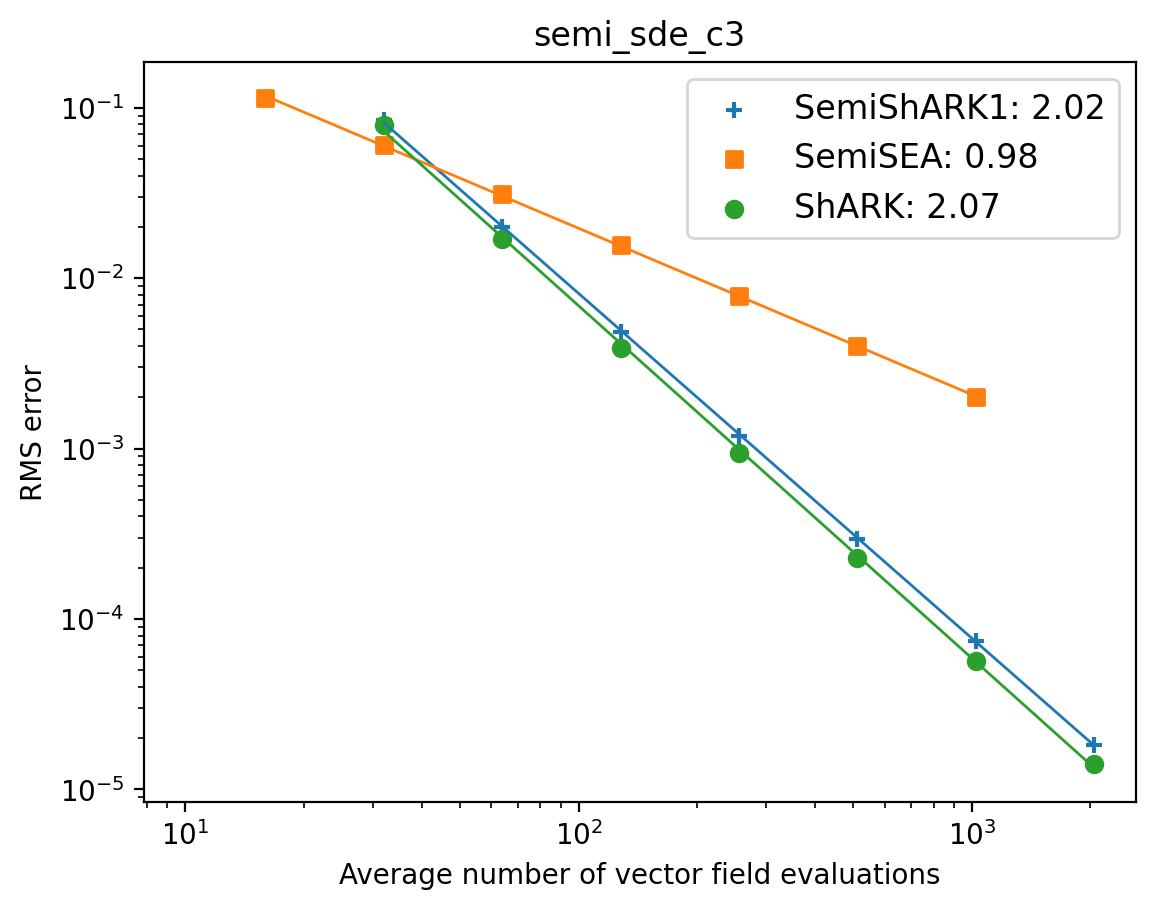

In [24]:
# compute the strong order of convergence for SDE 3
semi_shark_out3 = constant_step_strong_order(
    keys,
    sde3_semi,
    SemiShARK1(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols3,
)
save_order_results(semi_shark_out3, "semi_sde3_SemiShARK1")
semi_shark_out3 = load_order_results("semi_sde3_SemiShARK1")

# semi_sea_out3 = constant_step_strong_order(
#     keys, sde3_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols3
# )
# save_order_results(semi_sea_out3, "semi_sde3_SemiSEA")
semi_sea_out3 = load_order_results("semi_sde3_SemiSEA")

# shark_out3 = constant_step_strong_order(
#     keys,
#     sde3_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols3,
# )
# save_order_results(shark_out3, "semi_sde3_ShARK")
shark_out3 = load_order_results("semi_sde3_ShARK")

_ = draw_order_multiple_dict(
    {"SemiShARK1": semi_shark_out3, "SemiSEA": semi_sea_out3, "ShARK": shark_out3},
    "semi_sde_c3",
)

Saved data/order_results_semi_sde1_SemiShARK1.npy
Loaded data/order_results_semi_sde1_SemiShARK1.npy
Loaded data/order_results_semi_sde1_SemiSEA.npy
Loaded data/order_results_semi_sde1_ShARK.npy


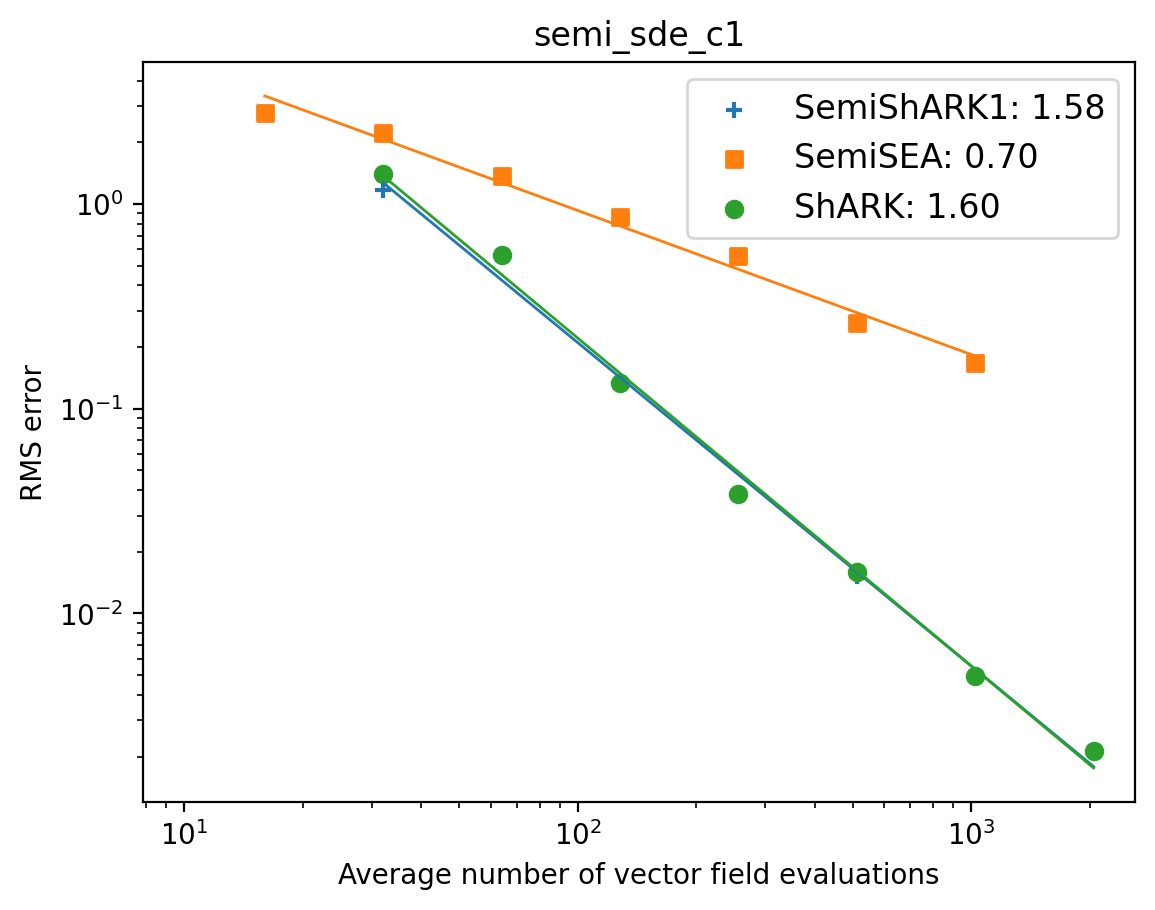

In [25]:
# compute the strong order of convergence for SDE 1

semi_shark_out1 = constant_step_strong_order(
    keys,
    sde1_semi,
    SemiShARK1(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols1,
)
save_order_results(semi_shark_out1, "semi_sde1_SemiShARK1")
semi_shark_out1 = load_order_results("semi_sde1_SemiShARK1")

# semi_sea_out1 = constant_step_strong_order(
#     keys, sde1_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols1
# )
# save_order_results(semi_sea_out1, "semi_sde1_SemiSEA")
semi_sea_out1 = load_order_results("semi_sde1_SemiSEA")

# shark_out1 = constant_step_strong_order(
#     keys,
#     sde1_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols1,
# )
# save_order_results(shark_out1, "semi_sde1_ShARK")
shark_out1 = load_order_results("semi_sde1_ShARK")

_ = draw_order_multiple_dict(
    {"SemiShARK1": semi_shark_out1, "SemiSEA": semi_sea_out1, "ShARK": shark_out1},
    "semi_sde_c1",
)

Saved data/order_results_semi_sde4_SemiShARK1.npy
Loaded data/order_results_semi_sde4_SemiShARK1.npy
Loaded data/order_results_semi_sde4_SemiSEA.npy
Loaded data/order_results_semi_sde4_ShARK.npy


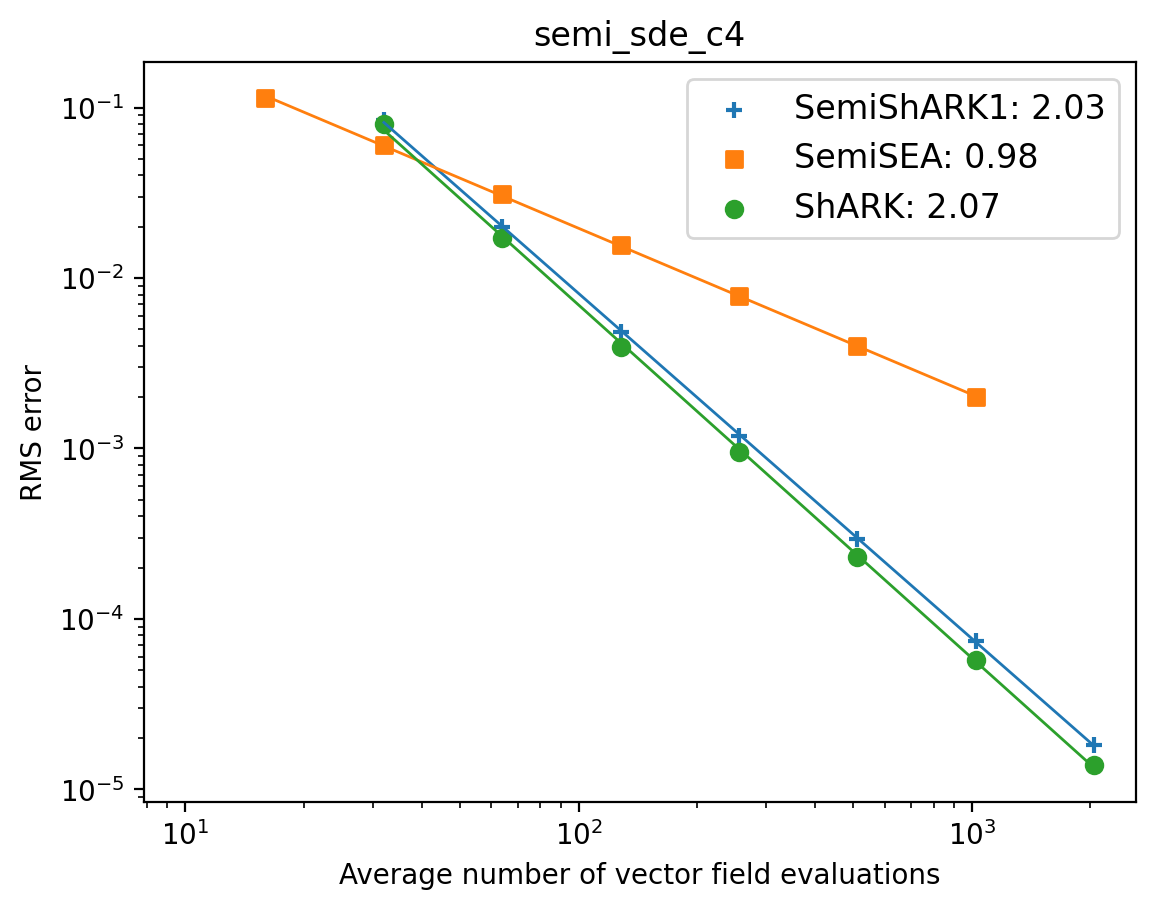

In [26]:
# compute the strong order of convergence for SDE 4
semi_shark_out4 = constant_step_strong_order(
    keys,
    sde4_semi,
    SemiShARK1(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols4,
)
save_order_results(semi_shark_out4, "semi_sde4_SemiShARK1")
semi_shark_out4 = load_order_results("semi_sde4_SemiShARK1")

# semi_sea_out4 = constant_step_strong_order(
#     keys, sde4_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols4
# )
# save_order_results(semi_sea_out4, "semi_sde4_SemiSEA")
semi_sea_out4 = load_order_results("semi_sde4_SemiSEA")

# shark_out4 = constant_step_strong_order(
#     keys,
#     sde4_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols4,
# )
# save_order_results(shark_out4, "semi_sde4_ShARK")
shark_out4 = load_order_results("semi_sde4_ShARK")

_ = draw_order_multiple_dict(
    {"SemiShARK1": semi_shark_out4, "SemiSEA": semi_sea_out4, "ShARK": shark_out4},
    "semi_sde_c4",
)

Saved data/order_results_semi_sde2_SemiShARK1.npy
Loaded data/order_results_semi_sde2_SemiShARK1.npy
Loaded data/order_results_semi_sde2_SemiSEA.npy
Loaded data/order_results_semi_sde2_ShARK.npy


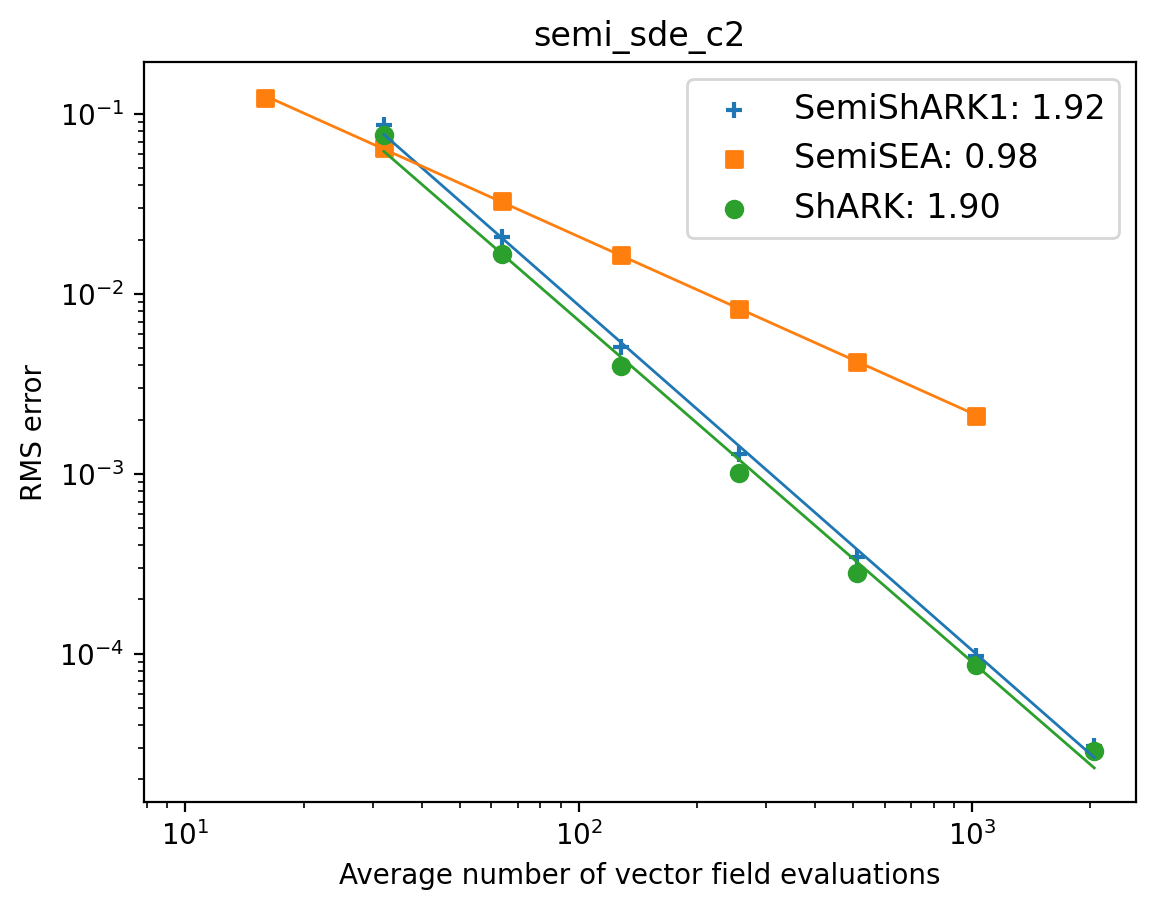

In [28]:
# compute the strong order of convergence for SDE 2
semi_shark_out2 = constant_step_strong_order(
    keys,
    sde2_semi,
    SemiShARK1(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols2,
)
save_order_results(semi_shark_out2, "semi_sde2_SemiShARK1")
semi_shark_out2 = load_order_results("semi_sde2_SemiShARK1")

# semi_sea_out2 = constant_step_strong_order(
#     keys, sde2_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols2
# )
# save_order_results(semi_sea_out2, "semi_sde2_SemiSEA")
semi_sea_out2 = load_order_results("semi_sde2_SemiSEA")

# shark_out2 = constant_step_strong_order(
#     keys,
#     sde2_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols2,
# )
# save_order_results(shark_out2, "semi_sde2_ShARK")
shark_out2 = load_order_results("semi_sde2_ShARK")

_ = draw_order_multiple_dict(
    {"SemiShARK1": semi_shark_out2, "SemiSEA": semi_sea_out2, "ShARK": shark_out2},
    "semi_sde_c2",
)